Task 1. Sentiment Classification

In [44]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import matplotlib.pyplot as plt
import seaborn as sns
from argparse import Namespace
import os

In [17]:
df = pd.read_csv('reviews_with_splits_lite.csv')
df.head()

,rating,review,split
0,negative,"I will never again visit the VCA Fox Chapel, a...",train
1,negative,Food is mediocre service is lousy. I'm sitting...,train
2,negative,Who deleted my review of Sunnyledge?\n\nBack i...,train
3,negative,I went here for a business lunch the other day...,train
4,negative,This business closed July 31st 2014!!,train


EDA - Exploratory Data Analysis

Basic information：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7280 entries, 0 to 7279
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            7280 non-null   object
 1   review            7280 non-null   object
 2   split             7280 non-null   object
 3   processed_review  7280 non-null   object
dtypes: object(4)
memory usage: 227.6+ KB
None

DIstribution of sentiment labels：
rating
negative    3640
positive    3640
Name: count, dtype: int64


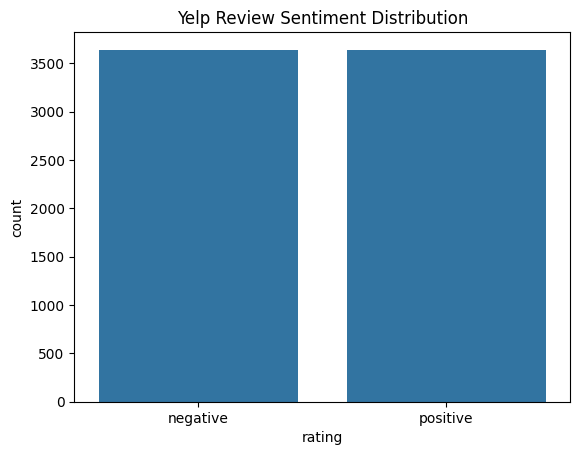

In [27]:
# EDA - Exploratory Data Analysis

print("Basic information：")
print(df.info())
print("\nDIstribution of sentiment labels：")
print(df['rating'].value_counts())

# Visualizing the distribution of sentiment labels
sns.countplot(x='rating', data=df)
plt.title("Yelp Review Sentiment Distribution")
plt.show()


Data Preprocess

In [ ]:
# Data Preprocess - Defining the text preprocessing function

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Replacing the original labels with binary labels (0 for negative, 1 for positive)
df['rating'] = df['rating'].apply(lambda x: 1 if x == 'positive' else 0)


def preprocess_text(text):
    # Decapitalization and removing special characters
    text = text.lower() 
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # spliting words into list
    words = text.split()
    # stop words removal
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # returning into string
    return ' '.join(words)

df['processed_review'] = df['review'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lilai\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lilai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lilai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# seperating the data into train, validation and test sets

train_text = df[df['split'] == 'train']['processed_review'].values
train_labels = df[df['split'] == 'train']['rating'].values
val_text = df[df['split'] == 'val']['processed_review'].values
val_labels = df[df['split'] == 'val']['rating'].values
test_text = df[df['split'] == 'test']['processed_review'].values
test_labels = df[df['split'] == 'test']['rating'].values

In [35]:
# TFIDF vectorization
vectorizer = TfidfVectorizer(max_features=5000) # limiting to top 5000 features, preventing overfitting
X_train = vectorizer.fit_transform(train_text).toarray()
X_val = vectorizer.transform(val_text).toarray()
X_test = vectorizer.transform(test_text).toarray()

# Converting to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(train_labels, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(val_labels, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(test_labels, dtype=torch.long)

In [36]:
# defining a custom dataset for reviews
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [37]:
# Data loader

batch_size = 64
train_loader = DataLoader(TextDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TextDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)
test_loader = DataLoader(TextDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)


Model

In [38]:
class ReviewClassifier(nn.Module):
    """ a simple perceptron based classifier """
    def __init__(self, num_features, hidden_dim):
        """
        Args:
            num_features (int): the size of the input feature vector
            hidden_dim   (int): the size of hidden dimension
        """
        super(ReviewClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=num_features, out_features=hidden_dim)
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=1)

    def forward(self, x_in):
        """The forward pass of the classifier    
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be [batch, num_features]
        Returns:
            the resulting tensor. tensor.shape should be [batch]
        """
        intermediate = self.fc1(x_in)            # [batch, num_features] -> [batch, hidden_dim]
        intermediate = F.relu(intermediate)      # [batch, hidden_dim]
        y_out = self.fc2(intermediate)           # [batch, hidden_dim] -> [batch, out_features]
               
        return torch.sigmoid(y_out).squeeze()    # [batch, 1] -> [batch] (e.g., [0.3, 0.1, 0.7, 0.8, ..., 0.5])

In [39]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t  # update 'early_stopping_best_val'

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (y_pred>0.5).cpu().long()
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()  # item() to get a Python number from a tensor containing a single value
    return n_correct / len(y_pred_indices) * 100

In [40]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [ ]:
args = Namespace(
    # Data and Path information
    frequency_cutoff=25,
    model_state_file='model.pth',
    review_csv='reviews_with_splits_lite.csv',
    save_dir='model_storage/',
    # No Model hyper parameters
    hidden_dim=20,
    # Training hyper parameters
    batch_size=128,
    early_stopping_criteria=5,
    learning_rate=0.001,
    num_epochs=100,
    seed=1337,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)    
    print("Expanded filepaths: ")
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs ; creat dirs if they don't exist
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/ch3/yelp/model.pth
Using CUDA: False


In [47]:
print("Loading dataset and creating vectorizer")
# create dataset and vectorizer
dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv, args.frequency_cutoff) 

vectorizer = dataset.get_vectorizer()

classifier = ReviewClassifier(num_features=len(vectorizer.review_vocab), hidden_dim=args.hidden_dim)

Loading dataset and creating vectorizer


AttributeError: type object 'ReviewDataset' has no attribute 'load_dataset_and_make_vectorizer'

In [ ]:
str(vectorizer.review_vocab), str(vectorizer.rating_vocab)

In [ ]:
classifier = classifier.to(args.device)

loss_func = nn.BCELoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.1,
                                                 patience=10) # Reduce learning rate when a metric has stopped improving.

train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', total=args.num_epochs, position=0)  # progress bar

dataset.set_split('train')
train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

dataset.set_split('val')
val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float())  # [batch, num_features] -> [batch]

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # update bar
            train_bar.set_postfix(loss=running_loss, 
                                  acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()
        
        train_state['train_loss'].append(running_loss)  # train_loss for each epoch
        train_state['train_acc'].append(running_acc)    # train_acc for each epoch
        
        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        with torch.no_grad():
          for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float())

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            val_bar.set_postfix(loss=running_loss, 
                                acc=running_acc, 
                                epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)  # val_loss for each epoch
        train_state['val_acc'].append(running_acc)    # val_acc for each epoch

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])  # adjust learning rate

        if train_state['stop_early']:
            break

        train_bar.reset()   # reset number of finished iterations
        val_bar.reset()
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

In [ ]:
import plotly.graph_objects as go

acc = train_state['train_acc']
val_acc = train_state['val_acc']
loss = train_state['train_loss']
val_loss = train_state['val_loss']

epochs = list(range(1, len(acc) + 1))

# Create interactive line chart
fig = go.Figure()

for y, name, color, mode in [(loss, 'Training Loss', 'blue', 'lines+markers'),
                             (val_loss, 'Validation Loss', 'royalblue', 'lines')]:
    fig.add_trace(go.Scatter(x=epochs, y=y, mode=mode, name=name, line=dict(color=color)))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis_title='Epochs',
    yaxis_title='Loss',
    legend=dict(x=0.02, y=0.98)
)

fig.show()

In [ ]:
# Create interactive line chart for accuracy
fig = go.Figure()

for y, name, color, mode in [(acc, 'Training Accuracy', 'blue', 'lines+markers'),
                             (val_acc, 'Validation Accuracy', 'royalblue', 'lines')]:
    fig.add_trace(go.Scatter(x=epochs, y=y, mode=mode, name=name, line=dict(color=color)))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis_title='Epochs',
    yaxis_title='Accuracy',
    legend=dict(x=0.02, y=0.98)
)

fig.show()

豆包

In [ ]:


class SentimentMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1=256, hidden_dim2=128, output_dim=5, dropout_rate=0.3):
        super(SentimentMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.BatchNorm1d(hidden_dim1),  # 批归一化
            nn.ReLU(),
            nn.Dropout(dropout_rate),     # Dropout防止过拟合
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.BatchNorm1d(hidden_dim2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim2, output_dim)
        )
    
    def forward(self, x):
        return self.model(x)

# 初始化模型
input_dim = X_train.shape[1]  # TF-IDF特征维度
model = SentimentMLP(input_dim)

# ====================== 3. 训练与优化（优化点：调整学习率+选择优化器） ======================
# 损失函数+优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 优化点：学习率0.001（可尝试0.0005/0.002）
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)  # 学习率衰减

# 训练函数
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    best_val_acc = 0.0
    train_losses = []
    val_losses = []
    val_accs = []
    
    for epoch in range(epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_X.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_true = []
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item() * batch_X.size(0)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.numpy())
                val_true.extend(batch_y.numpy())
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_acc = accuracy_score(val_true, val_preds)
        val_accs.append(val_acc)
        
        # 学习率衰减
        scheduler.step(val_loss)
        
        # 保存最优模型
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), './models/sentiment_model.pth')
        
        # 打印日志
        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
    
    return train_losses, val_losses, val_accs, best_val_acc

# 开始训练
train_losses, val_losses, val_accs, best_val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20)

# ====================== 4. 测试最优模型 ======================
# 加载最优模型
best_model = SentimentMLP(input_dim)
best_model.load_state_dict(torch.load('./models/sentiment_model.pth'))
best_model.eval()

# 测试集评估
test_preds = []
test_true = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = best_model(batch_X)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.numpy())
        test_true.extend(batch_y.numpy())
test_acc = accuracy_score(test_true, test_preds)
test_loss = criterion(best_model(X_test_tensor), y_test_tensor).item()

print(f'最优模型测试准确率: {test_acc:.4f} | 测试损失: {test_loss:.4f}')

# ====================== 5. 超参数调优（对比5组模型） ======================
# 示例：调整不同超参数组合，记录结果
hyper_params = [
    {'hidden_dim1': 128, 'hidden_dim2': 64, 'lr': 0.001, 'dropout': 0.2},
    {'hidden_dim1': 256, 'hidden_dim2': 128, 'lr': 0.001, 'dropout': 0.3},
    {'hidden_dim1': 512, 'hidden_dim2': 256, 'lr': 0.001, 'dropout': 0.3},
    {'hidden_dim1': 256, 'hidden_dim2': 128, 'lr': 0.0005, 'dropout': 0.3},
    {'hidden_dim1': 256, 'hidden_dim2': 128, 'lr': 0.001, 'dropout': 0.4},
]

# 记录5组模型的结果（简化版，实际需完整训练）
results = []
for i, params in enumerate(hyper_params):
    print(f'训练第{i+1}组模型: {params}')
    temp_model = SentimentMLP(input_dim, params['hidden_dim1'], params['hidden_dim2'], dropout_rate=params['dropout'])
    temp_optimizer = optim.Adam(temp_model.parameters(), lr=params['lr'])
    _, _, _, temp_best_val_acc = train_model(temp_model, train_loader, val_loader, criterion, temp_optimizer, epochs=15)
    
    # 测试集评估
    temp_model.eval()
    temp_test_preds = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = temp_model(batch_X)
            _, preds = torch.max(outputs, 1)
            temp_test_preds.extend(preds.numpy())
    temp_test_acc = accuracy_score(test_true, temp_test_preds)
    
    results.append({
        'params': params,
        'val_acc': temp_best_val_acc,
        'test_acc': temp_test_acc,
        'test_loss': criterion(temp_model(X_test_tensor), y_test_tensor).item()
    })

# 打印5组模型结果（用于报告）
for i, res in enumerate(results):
    print(f'第{i+1}组模型 | 验证准确率: {res["val_acc"]:.4f} | 测试准确率: {res["test_acc"]:.4f} | 测试损失: {res["test_loss"]:.4f}')

KeyboardInterrupt: 